# Offset-free linear MPC of a stirred-tank reactor

This notebook is designed based on Rawlings's book (Chapter 1.5).

<!-- ![tank](./figures/stirred_tank_reactor.png) -->
<img src="./figures/stirred_tank_reactor.png" alt="tank" class="bg-primary mb-1" width="500px">


The mass and energy balances that characterize a reaction $\mathcal{A} \to \mathcal{B}$ occurring in the well-stirred chemical reactor is described by the following nonlinear state space model:

$$
\begin{equation}
\left\{
\begin{aligned}
&\dot{c}(t) = \frac{F_0 (c_0 - c(t))}{\pi r^2 h(t)} - k_0 \, c(t) \, e^{-\tfrac{E}{RT}}\\
&\dot{T}(t) = \frac{F_0 (T_0 - T(t))}{\pi r^2 h(t)} - \frac{\Delta H}{\rho C_p} k_0 c(t) \, e^{-\tfrac{E}{RT}} + \frac{2 U}{r \rho C_p}(T_c - T(t))\\
& \dot{h}(t) =  \frac{F_0 - F}{\pi r^2},
\end{aligned}
\right.
\end{equation}
$$

where $h$ is the level of the tank, $c$ the molar concentration of species $\mathcal{A}$ and $T$ represents the temperature of the reactor. 

The input control are $T_c$ and $F$, the coolant liquid temperature and the outlet flow-rate, respectively. 

Moreover, the inlet flow-rate $F_0$ acts as an **unmeasured disturbance**.
With the nominal values summarized in the table, the open-loop steady-state operating conditions are:

$$
c_{\textup{ref}} = 0.878 \, \text{[kmol/$\text{m}^3$]}, \; T_{\textup{ref}} = 324.5 \, \text{[K]}, \; h_{\textup{ref}} = 0.659 \, \text{[m]},
$$
$$
T_{c_\textup{ref}} = 300 \, \text{[K]}, \; F_{\textup{ref}} = 0.1 \, \text{[$\text{m}^3$/min]}.
$$ -->

| Parameter  | Nominal value  | Unit |
|------------|---------------|------|
| $F_0$   | 0.1           | $[\text{m}^3/\text{min}]$ |
| $T_0$   | 350           | $[\text{K}]$ |
| $c_0$   | 1             | $[\text{kmol}/\text{m}^3]$ |
| $r$     | 0.219         | $[\text{m}]$ |
| $k_0$   | $7.2 \times 10^{10}$ | $[\text{min}^{-1}]$ |
| $E/R$   | 8750          | $[\text{K}]$ |
| $U$     | 54.94         | $[\text{kJ}/(\text{min} \cdot \text{m}^2 \cdot \text{K})]$ |
| $\rho$  | 1000          | $[\text{kg}/\text{m}^3]$ |
| $C_p$   | 0.239         | $[\text{kJ}/(\text{kg} \cdot \text{K})]$ |
| $\Delta H$ | $-5 \times 10^4$ | $[\text{kJ}/\text{kmol}]$ |

By introducing the following measurable state variables, control inputs and disturbance
	$$
	x = \left[\begin{array}{c}
	c - c_{\textup{ref}}\\
	T - T_{\textup{ref}}\\
	h - h_{\textup{ref}}
	\end{array}
	\right], \; u = \left[\begin{array}{c}
	T_c - T_{c_{\textup{ref}}}\\
	F-F_{\textup{ref}}\\
	\end{array}
	\right], \; p = F_0 - F_{0_{\textup{ref}}},
	$$
	linearize  the nonlinear system around the steady-state operating conditions and discretize by using a sampling time of $1 \, \text{[min]}$ to get:
	$$
	\left\{
	\begin{aligned}
		&x(k+1) = A x(k) + B u(k) + B_{\textup{p}} p\\
		&y(k) = C x(k),
	\end{aligned}
	\right.
	$$
	with the following numerical values
	$$
	A = \left[\begin{array}{ccc}
	0.2682 &  -0.0034 &  -0.0073\\
	9.6985 &   \phantom{-}0.3277  & -25.4364\\
	0    &     \phantom{-}0  &  \phantom{-}1
	\end{array}\right], \; 
	B = \left[\begin{array}{cc}
	-0.0054 &   \phantom{-}0.1655\\
	\phantom{-}1.2964  &  \phantom{-}97.8998\\
	\phantom{-}0  & -6.6368
	\end{array}\right]
	$$
	$$
	B_{\textup{p}} = \left[\begin{array}{c}
   -0.1174\\
	\phantom{-}69.7264\\
	\phantom{-}6.6368
	\end{array}\right], \; C = I_3.
	$$




Let us design the controller to **remove the offset**. We begin by solving the following optimization problem to compute the infinite horizon optimal cost and control law for the unconstrained system
$$
\mathbb{P}^{\textup{uc}}_\infty(x) \, : \, \min_{\boldsymbol{u}} \sum_{k = 0}^{\infty} \left(\|y(k)\|^2_Q + \|u(k)\|^2_R\right),
$$
with
$$
Q = \left[\begin{array}{ccc}
	1.2977    &     0    &     0\\
0   & 0   &      0\\
0    &     0  &  2.3027
\end{array}
\right], \, R = \left[\begin{array}{ccc}
1 & 0\\
0 & 100
\end{array}
\right].
$$

In [24]:
import numpy as np
from control import dare
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

A = np.array([
    [0.2682, -0.0034, -0.0073],
    [9.6985, 0.3277, -25.4364],
    [0., 0., 1.]
])
B = np.array([
    [-0.0054, 0.1655],
    [1.2964, 97.8998],
    [0., -6.6368]
])
Bp = np.array([-0.1174, 69.7264, 6.6368])

C = np.eye(3)
nx = A.shape[0]
nu = B.shape[1]

Q = np.array([
    [1.2977, 0., 0.],
    [0., 0., 0.],
    [0., 0., 2.3027]
])
R = np.array([
    [1., 0.],
    [0., 100.]
])

P_inf, _, K_inf = dare(A, B, Q, R)
K_inf = -K_inf
print(f"P_inf:\n {P_inf}")
print(f"K_inf:\n {K_inf}")

P_inf:
 [[ 1.393 -0.001  0.005]
 [-0.001  0.    -0.   ]
 [ 0.005 -0.     3.722]]
K_inf:
 [[ 0.002 -0.     0.001]
 [-0.    -0.     0.094]]


Let us see what will happen when directly using the infinite horizon LQR to control the linearized system.

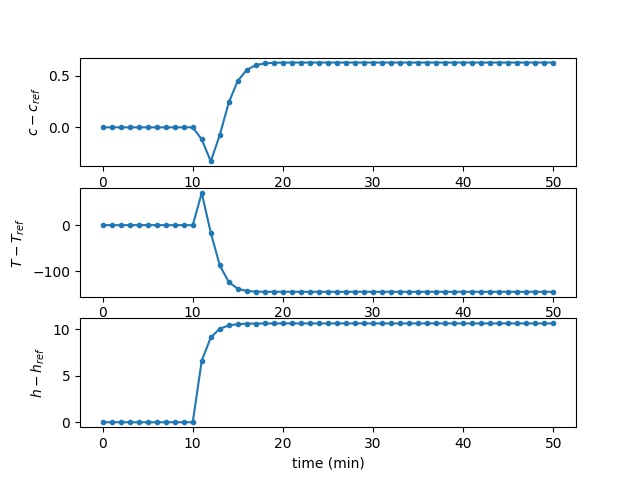

In [25]:
num_sim_steps  = 50
ps = np.ones(num_sim_steps)
ps[:10] = 0
ps[10:] *= 1

x0 = np.array([0., 0., 0.])
x_hist = np.zeros((num_sim_steps + 1, nx))
x_hist[0] = x0
for k in range(num_sim_steps):
    x = x_hist[k]
    u = K_inf @ x
    x_next = A @ x + B @ u + Bp * ps[k] # simulate the linearized system
    x_hist[k+1] = x_next
    
%matplotlib ipympl
fig, ax = plt.subplots(3, 1)
ax[0].plot(x_hist[:, 0], '-o', markersize=3)
ax[0].set_ylabel(r'$c - c_{ref}$')

ax[1].plot(x_hist[:, 1], '-o', markersize=3)
ax[1].set_ylabel(r'$T - T_{ref}$')

ax[2].plot(x_hist[:, 2], '-o', markersize=3)
ax[2].set_ylabel(r'$h - h_{ref}$')
ax[2].set_xlabel('time (min)')
plt.show()

Unfortunately, we observe some offsets caused by the unmeasured disturbance. To compensate for the disturbance, we model the disturbance and estimate it. We augment the system state with an integrating disturbance $d$
$$
d ^+ = d.
$$
The augmented system model used for the **state estimator** is 
$$
\begin{aligned}
\begin{bmatrix}
x \\ d
\end{bmatrix}^+ &=
\begin{bmatrix} 
A & B_d \\
0 & I 
\end{bmatrix}
\begin{bmatrix}
x \\ d
\end{bmatrix} + 
\begin{bmatrix}
B \\ 0
\end{bmatrix} u \\
y &= \begin{bmatrix}
C & C_d
\end{bmatrix}
\begin{bmatrix}
x \\ d
\end{bmatrix}
\end{aligned}
$$
We should choice $B_d$ and $C_d$ such that the augmented system is detectable. Next, we design a Luenberger observer to estimate the state and the integrating disturbance as follow:
$$
\begin{bmatrix}
\hat{x} \\ \hat{d}
\end{bmatrix}^+ =
\underbrace{\begin{bmatrix} 
A & B_d \\
0 & I 
\end{bmatrix}}_{\tilde{A}}
\begin{bmatrix}
x \\ d
\end{bmatrix} + 
\begin{bmatrix}
B \\ 0
\end{bmatrix} u + 
\underbrace{\begin{bmatrix}
L_1 \\ L_2 
\end{bmatrix}}_{\tilde{L}}
\left(
y - \underbrace{\begin{bmatrix}
C & C_d
\end{bmatrix}}_{\tilde{C}}
\begin{bmatrix}
\hat{x} \\ \hat{d}
\end{bmatrix}
\right).
$$
The design requirement is that $\tilde{A} - \tilde{L}\tilde{C}$ is stable. With the estimated disturbance, we use a **target selector** to modify the steady-state target.

### Offset-free MPC
- Measure current output

- Update state and disturbance estimates, $\hat{x}, \hat{d}$

- Select optimal target, $x_{\text{ref}}, d_{\text{ref}}$, given the disturbance estimate $\hat{d}$

- Solve optimal control problem for $\tilde{x} = \hat{x} - x_{\text{ref}}$, $\tilde{u} = \hat{u} - u_{\text{ref}}$

- Apply MPC control law: $u^* = \tilde{u}^* + u_{\text{ref}}$

- Advance state estimates

### First trial
- Model the disturbance $d$ with two integrating output disturbances on the two state variables $c$ and $h$.

$$
C_d = \begin{bmatrix}
    1 & 0 \\
    0 & 0 \\
    0 & 1
\end{bmatrix} \quad
B_d = 0
$$

- Simulate the response of the closed-loop system after a $10\%$ increase in the inlet flow-rate $F_0$ at time $t = 10$ [min]. Use the linearized model for the plant model. 

- Determine if there are any steady offset on the outputs.

In [26]:
nd = 2
Cd = np.array([
    [1., 0.],
    [0., 0.],
    [0., 1.]
])
Bd = np.zeros((nx, nd))

# nd = 3
# Bd = np.zeros((nx, nd))
# Bd[:, 2] = B[:, 1]
# Cd = np.array([
#     [1., 0., 0.],
#     [0., 0., 0.],
#     [0., 1., 0.]
# ])with_terminal_constraint

A_aug = np.block([
    [A, Bd],
    [np.zeros((nd, nx)), np.eye(nd)]
])  
B_aug = np.vstack([B, np.zeros((nd, nu))])
C_aug = np.hstack([C, Cd])
nx_aug = A_aug.shape[0]
# print(f"A_aug:\n {A_aug}")
# print(f"B_aug:\n {B_aug}")
# print(f"C_aug:\n {C_aug}")

# Detectability test
detec = np.linalg.matrix_rank(
    np.vstack([np.eye(nx + nd) - A_aug, C_aug])
)
print(f"Rank of the detectability matrix: {detec}")
if detec < nx + nd:
    print("The system is not detectable")

Rank of the detectability matrix: 5


In [27]:
from scipy.signal import place_poles

# Define desired eigenvalues (observer pole placements)
eigenplace = np.array([-0.3188, 0.6763, 0.3933 + 0.1810j, 0.3933 - 0.1810j, 0])

# eigenplace = [0.5437 + 0.9125j, 0.5437 - 0.9125j, -0.3122, 0.1263, 0.5485, 0.6854]

# Compute observer gain matrix L
place_result = place_poles(A_aug.T, C_aug.T, eigenplace)
L = place_result.gain_matrix.T

# Extract Lx and Ld
Lx = L[:nx, :]
Ld = L[nx:, :]

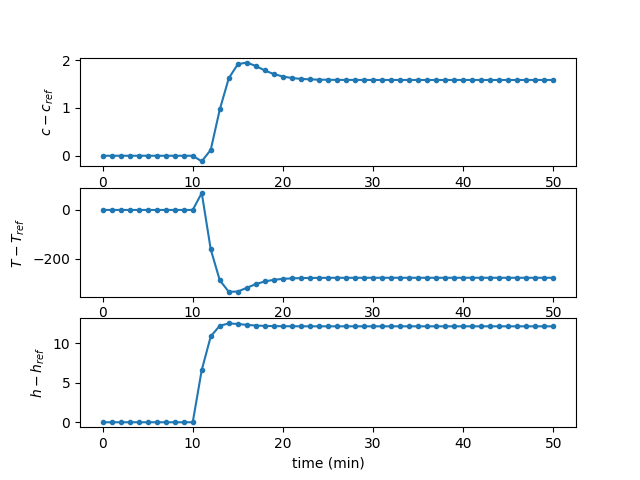

In [28]:
x0 = np.array([0., 0., 0.])
x_hist = np.zeros((num_sim_steps + 1, nx))
x_hist[0] = x0
xhat_hist = np.zeros((num_sim_steps, nx))
dhat_hist = np.zeros((num_sim_steps, nd))
xhat_ = np.zeros(nx)
dhat_ = np.zeros(nd)

H = np.array([
    [1., 0., 0.], 
    [0., 0., 1.],
])
G = np.block([
    [np.eye(nx) - A, -B],
    [H @ C, np.zeros((H.shape[0], nu))]
])
Ginv = np.linalg.inv(G) # G is invertible!

yset = np.array([0., 0., 0.])

for k in range(num_sim_steps):
    x = x_hist[k]
    
    # Measurement
    y = C @ x
    
    # State estimation
    ey = y - C @ xhat_ - Cd @ dhat_
    xhat = xhat_ + Lx @ ey
    dhat = dhat_ + Ld @ ey
    xhat_hist[k] = xhat
    dhat_hist[k] = dhat
    
    # Target selection    
    qs = Ginv @ np.hstack([Bd @ dhat, H @ (yset - Cd @ dhat)])
    xs = qs[:nx]
    us = qs[nx:]
    
    # Implement LQR
    u = K_inf @ (xhat - xs) + us
    
    # Simulation
    x_next = A @ x + B @ u + Bp * ps[k]
    x_hist[k+1] = x_next

    # Advance state estimates
    xhat_ = A @ xhat_hist[k] + B @ u + Bd @ dhat_hist[k] 
    dhat_ = dhat_hist[k]

fig, ax = plt.subplots(3, 1)
ax[0].plot(x_hist[:, 0], '-o', markersize=3)
ax[0].set_ylabel(r'$c - c_{ref}$')

ax[1].plot(x_hist[:, 1], '-o', markersize=3)
ax[1].set_ylabel(r'$T - T_{ref}$')

ax[2].plot(x_hist[:, 2], '-o', markersize=3)
ax[2].set_ylabel(r'$h - h_{ref}$')
ax[2].set_xlabel('time (min)')
plt.show()

### Second trial
- Choose a disturbance model with three integrating modes

$$
C_d = \begin{bmatrix}
    1 & 0 & 0 \\
    0 & 0 & 1\\
    0 & 1 & 0 
\end{bmatrix} \quad
B_d = 0
$$

In [33]:
nd = 3
Bd = np.zeros((nx, nd))
Cd = np.array([
    [1., 0., 0.],
    [0., 0., 1.],
    [0., 1., 0.]
])

A_aug = np.block([
    [A, Bd],
    [np.zeros((nd, nx)), np.eye(nd)]
])  
B_aug = np.vstack([B, np.zeros((nd, nu))])
C_aug = np.hstack([C, Cd])
nx_aug = A_aug.shape[0]

# Detectability test
detec = np.linalg.matrix_rank(
    np.vstack([np.eye(nx + nd) - A_aug, C_aug])
)
print(f"Rank of the detectability matrix: {detec}")
if detec < nx + nd:
    print("The system is not detectable")

Rank of the detectability matrix: 5
The system is not detectable


The augmented system is not detectable with this disturbance model.

### Third trial
- Choose a disturbance model with three integrating modes

- Choose two integrating output disturbances on the two state variables

- Choose one integrating input disturbance on the outlet flow-rate $F$

$$
C_d = \begin{bmatrix}
    1 & 0 & 0 \\
    0 & 0 & 0\\
    0 & 1 & 0 
\end{bmatrix} \quad
B_d = \begin{bmatrix}
    0 & 0 & 0.1655 \\
    0 & 0 & 97.91 \\
    0 & 0 & -6.637 
\end{bmatrix}
$$

In [34]:
nd = 3
Bd = np.zeros((nx, nd))
Bd[:, 2] = B[:, 1]
Cd = np.array([
    [1., 0., 0.],
    [0., 0., 0.],
    [0., 1., 0.]
])

A_aug = np.block([
    [A, Bd],
    [np.zeros((nd, nx)), np.eye(nd)]
])  
B_aug = np.vstack([B, np.zeros((nd, nu))])
C_aug = np.hstack([C, Cd])
nx_aug = A_aug.shape[0]
# print(f"A_aug:\n {A_aug}")
# print(f"B_aug:\n {B_aug}")
# print(f"C_aug:\n {C_aug}")

# Detectability test
detec = np.linalg.matrix_rank(
    np.vstack([np.eye(nx + nd) - A_aug, C_aug])
)
print(f"Rank of the detectability matrix: {detec}")
if detec < nx + nd:
    print("The system is not detectable")

Rank of the detectability matrix: 6


In [35]:
from scipy.signal import place_poles

# Define desired eigenvalues (observer pole placements)
eigenplace = [0.5437 + 0.9125j, 0.5437 - 0.9125j, -0.3122, 0.1263, 0.5485, 0.6854]

# Compute observer gain matrix L
place_result = place_poles(A_aug.T, C_aug.T, eigenplace)
L = place_result.gain_matrix.T

# Extract Lx and Ld
Lx = L[:nx, :]
Ld = L[nx:, :]

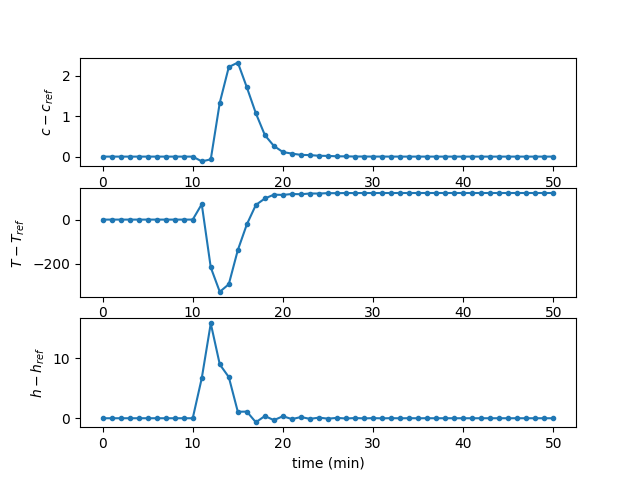

In [36]:
x0 = np.array([0., 0., 0.])
x_hist = np.zeros((num_sim_steps + 1, nx))
x_hist[0] = x0

xhat_hist = np.zeros((num_sim_steps, nx))
dhat_hist = np.zeros((num_sim_steps, nd))
xhat_ = np.zeros(nx)
dhat_ = np.zeros(nd)

H = np.array([
    [1., 0., 0.], 
    [0., 0., 1.],
])
G = np.block([
    [np.eye(nx) - A, -B],
    [H @ C, np.zeros((H.shape[0], nu))]
])
Ginv = np.linalg.inv(G) # G is invertible!

yset = np.array([0., 0., 0.])

for k in range(num_sim_steps):
    x = x_hist[k]
    
    # Measurement
    y = C @ x
    
    # State estimation
    ey = y - C @ xhat_ - Cd @ dhat_
    xhat = xhat_ + Lx @ ey
    dhat = dhat_ + Ld @ ey
    xhat_hist[k] = xhat
    dhat_hist[k] = dhat
    
    # Target selection    
    qs = Ginv @ np.hstack([Bd @ dhat, H @ (yset - Cd @ dhat)])
    xs = qs[:nx]
    us = qs[nx:]
    
    # Implement LQR
    u = K_inf @ (xhat - xs) + us
    
    # Simulation
    x_next = A @ x + B @ u + Bp * ps[k]
    x_hist[k+1] = x_next

    # Advance state estimates
    xhat_ = A @ xhat_hist[k] + B @ u + Bd @ dhat_hist[k] 
    dhat_ = dhat_hist[k]

fig, ax = plt.subplots(3, 1)
ax[0].plot(x_hist[:, 0], '-o', markersize=3)
ax[0].set_ylabel(r'$c - c_{ref}$')

ax[1].plot(x_hist[:, 1], '-o', markersize=3)
ax[1].set_ylabel(r'$T - T_{ref}$')

ax[2].plot(x_hist[:, 2], '-o', markersize=3)
ax[2].set_ylabel(r'$h - h_{ref}$')
ax[2].set_xlabel('time (min)')
plt.show()